# Visual Inspection of Motorcycle Connecting Rods
## Final implementation

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [13]:
def binarizeImage(img):
    # 3 pass of median blur, to remove iron powder
    img_filtered = cv2.medianBlur(img, 3)
    img_filtered = cv2.medianBlur(img_filtered, 3)
    img_filtered = cv2.medianBlur(img_filtered, 3)

    # binarize image
    th_otsu, img_bin = cv2.threshold(img_filtered, 0, 255, cv2.THRESH_OTSU)
    img_bin = 255-img_bin

    return img_bin, th_otsu

In [14]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def HaralickCircularity(cont):
    moments = cv2.moments(cont)
    B = int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])

    sum = 0
    for p in cont:
        sum += distance(B, p[0])
    
    mean = sum / len(cont)
    
    sum = 0
    for p in cont:
        sum += (distance(B, p[0]) - mean)**2
    
    variance = sum / len(cont)


    return mean/math.sqrt(variance)

In [15]:
# def removeContactPoints(img_bin):
#     img_rgb = np.stack([img_bin,img_bin,img_bin], axis=-1)  # to draw the line
#     cont, _ = cv2.findContours(image=img_bin, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

#     counter = 0
#     for c in cont:
#         counter += 1
#         print(counter)
#         c = cv2.approxPolyDP(c, 1, True)     # smooth the contours

#         hull_defects = cv2.convexHull(c, returnPoints=False)
#         defect_vec = cv2.convexityDefects(c, hull_defects)

#         if defect_vec is None:      # convex objects have no defect_points
#             defects = np.array([])
#         else:
#             defects = np.take(c.squeeze(1), defect_vec.squeeze(1)[:, 2], axis=0)
        
#         # Draw line to separate the components
#         th_dist = 15

#         for i in range(0, len(defects)):
#             p = defects[i]

#             min_dist = 10000
#             best_q = -1

#             for j in range(i+1, len(defects)):
#                 q = defects[j]
#                 dist = distance(p,q)
#                 if dist < min_dist:
#                     min_dist = dist
#                     best_q = q

#             if min_dist < th_dist:
#                 print(p)
#                 print(best_q)
#                 cv2.line(img_rgb, (p[0],p[1]), (best_q[0],best_q[1]), (0,0,0), 1, lineType=cv2.LINE_8)

#     return img_rgb[:,:,0]

In [16]:
def findRodContours(img_bin, th_bin):
    rod_type = []
    ext_cont = []
    holes_cont = []
    blobs = []

    th_area = 100
    th_circularity = 5
    th_defectDistance = 50

    connectivity = 8
    num_labels, labels, stats, centroid = cv2.connectedComponentsWithStats(img_bin, connectivity, th_bin,  cv2.CV_32S)

    for i in range(1,num_labels):   #first label is background
        area = stats[i, cv2.CC_STAT_AREA]

        # Remove residue of iron powder
        if area < th_area:
            labels[labels==i] = 0
            continue
        
        blob = (labels==i).astype("uint8") * 255
        cont, hierarchy = cv2.findContours(image=blob, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

        ext_cont_i = 0
        holes_cont_i = 0
        type_i = 0

        for idx, c in enumerate(hierarchy[0]):
            if c[3] == -1:  # if it has no parent, it is external
                
                if c[2] == -1:  # a rod must have at least one hole
                    continue    

                # Remove washers, check circularity
                circularity = HaralickCircularity(cont[idx])
                if circularity > th_circularity:
                    continue

                hole_1 = hierarchy[0][c[2]]

                if hole_1[0] == -1: # only one hole: type A
                    type_i = 'A'
                    ext_cont_i = cont[idx][:,0]
                    holes_cont_i = [cont[c[2]][:,0]]
                    continue

                hole_2 = hierarchy[0][hole_1[0]]

                if hole_2[0] == -1: # two holes: type B
                    type_i = 'B'
                    ext_cont_i = cont[idx][:,0]
                    holes_cont_i = [cont[c[2]][:,0], cont[hole_1[0]][:,0]]

                continue    # a rod cannot have more than two holes

        if type_i != 0:   # append only if it is a rod
            ext_cont.append(ext_cont_i)
            holes_cont.append(holes_cont_i)
            rod_type.append(type_i)
            blobs.append(blob)
        
    # Rebuild the image with only the blobs
    img_blob = np.zeros(img_bin.shape)
    for blob in blobs:
        img_blob = np.logical_or(img_blob, blob)
    img_blob = img_blob.astype("uint8")*255
    img_blob = np.stack([img_blob, img_blob, img_blob], axis=-1)    # 3 channel image to draw over it

    return img_blob, ext_cont, holes_cont, rod_type

In [17]:
def computeMinimumEnclosingRectangle(cont):
    # Moments of the blob
    moments = cv2.moments(cont)
    m00 = moments['m00']        # OpenCV compute moments as Mji = sum(x^j*y^i)
    m11 = moments['mu11']       # i,j inverted compared to the slide
    m10 = moments['m10']
    m01 = moments['m01']
    m20 = moments['mu20']
    m02 = moments['mu02']

    # Barycenter
    bx, by = int(m10/m00), int(m01/m00)

    # Orientation
    theta = -0.5*math.atan(2*m11/(m20-m02))
    theta = np.where(m20-m02 > 0, theta, theta+math.pi/2)   #the previous formula is a minimum(major axis)
                                                            #only if the denominator is > 0 ???
    theta = np.where(theta < 0, theta+math.pi, theta)   # orientation must be in the interval [0,pi]

    # Major and Minor axis
    alpha, beta = -math.sin(theta), math.cos(theta)

    a_MA = alpha
    b_MA = -beta
    c_MA = beta*by - alpha*bx
    MA = (a_MA, b_MA, c_MA)

    a_MI = beta
    b_MI = alpha
    c_MI = -beta*bx - alpha*by
    MI = (a_MI, b_MI, c_MI)

    # Compute the four points laying at maximum distance on opposite sides of the two axes
    dMAmin = float("inf")
    dMAmax = -float("inf")
    dMImin = float("inf")
    dMImax = -float("inf")

    i1, j1 = 0, 0   # Major axis, positive side
    i2, j2 = 0, 0   # Major axis, negative side
    i3, j3 = 0, 0   # Minor axis, positive side
    i4, j4 = 0, 0   # Minor axis, negative side

    normMA = math.sqrt(a_MA*a_MA + b_MA*b_MA)
    normMI = math.sqrt(a_MI*a_MI + b_MI*b_MI)

    for j, i in cont:
        dMA = (a_MA*j+b_MA*i+c_MA) / normMA
        dMI = (a_MI*j+b_MI*i+c_MI) / normMI

        if dMA < dMAmin:
            dMAmin = dMA
            i1, j1 = i, j

        if dMA > dMAmax:
            dMAmax = dMA
            i2, j2 = i, j

        if dMI < dMImin:
            dMImin = dMI
            i3, j3 = i, j

        if dMI > dMImax:
            dMImax = dMI
            i4, j4 = i, j

    # Offsets of the lines parallel to the major and minor axis
    cl1 = -a_MA*j1 - b_MA*i1
    cl2 = -a_MA*j2 - b_MA*i2
    cw1 = -a_MI*j3 - b_MI*i3
    cw2 = -a_MI*j4 - b_MI*i4

    # Vertex of the Minimum Enclosing Rectangle
    v1 = [(b_MA*cw1 - b_MI*cl1)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl1 - a_MA*cw1)/(a_MA*b_MI-b_MA*a_MI)]
    v2 = [(b_MA*cw2 - b_MI*cl1)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl1 - a_MA*cw2)/(a_MA*b_MI-b_MA*a_MI)]
    v3 = [(b_MA*cw1 - b_MI*cl2)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl2 - a_MA*cw1)/(a_MA*b_MI-b_MA*a_MI)]
    v4 = [(b_MA*cw2 - b_MI*cl2)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl2 - a_MA*cw2)/(a_MA*b_MI-b_MA*a_MI)]
    vrtx = np.array([v1,v2,v4,v3], np.int32)

    return vrtx, (bx,by), MA, MI, theta

In [18]:
def getRotatedROI(img, vrtx, W, L):
    dst = np.float32([[0,0], [W,0], [0,L], [W,L]])
    src = np.float32([vrtx[2], vrtx[1], vrtx[3], vrtx[0]])

    transform_matrix = cv2.getPerspectiveTransform(src,dst)
    roi = cv2.warpPerspective(img, transform_matrix, (W,L))
    return roi, transform_matrix

def computeBarycenterWidth(roi, B):
    y = int(B[0][0][1])
    x1, x2 = 0, 0
    previous_pixel = 0
    current_pixel = 0
    for i in range(1, roi.shape[1]):
        previous_pixel = current_pixel
        current_pixel = roi[y, i]
        if previous_pixel == 0 and current_pixel > 0:
            x1 = i
        if previous_pixel > 0 and current_pixel == 0:
            x2 = i
    
    return x2-x1

def computeBlobMeasure(img_bin, ext_cont, MER_vrtx, barycenters):
    lengths = []
    widths = []
    b_widths = []

    for i, (cont, vrtx, B) in enumerate(zip(ext_cont, MER_vrtx, barycenters)):
        W = distance(vrtx[0], vrtx[3])
        L = distance(vrtx[0], vrtx[2])
        roi, transform_matrix = getRotatedROI(img_bin, vrtx, int(W), int(L))
        Wb = computeBarycenterWidth(roi, cv2.perspectiveTransform(np.float32([[B]]), transform_matrix))

        lengths.append(L)
        widths.append(W)
        b_widths.append(Wb)

        # print("{}° rod:".format(i+1))
        # print(" width: {:.2f}".format(W))
        # print(" length: {:.2f}".format(L))
        # print(" width at B: {:.2f}".format(Wb))

    return lengths, widths, b_widths

In [19]:
def drawMER(img, MER_vrtx, color):
    for i, vrtx in enumerate(MER_vrtx):
        cv2.polylines(img, [vrtx], True, color[i][1])

    return img


def drawAxis(img, barycenters, orientation, lengths, widths):
    for i, (b, theta, L, W) in enumerate(zip(barycenters, orientation, lengths, widths)):
        pMA = (int(b[0] + L/6*math.cos(theta)), int(b[1] - L/6*math.sin(theta)))
        img = cv2.arrowedLine(img, b, pMA, (255,0,0))
        pMI = (int(b[0] + W/6*math.cos(theta+math.pi/2)), int(b[1] - W/6*math.sin(theta+math.pi/2)))
        img = cv2.arrowedLine(img, b, pMI, (0,0,255))
    
    return img


def drawContour(img, ext_cont, holes_cont, contour_color):
    for i, (e_cont, h_cont) in enumerate(zip(ext_cont, holes_cont)):
        e_cont = np.array(e_cont)
        e_cont = np.expand_dims(e_cont, axis=1)
        cv2.drawContours(img, [e_cont], -1, contour_color[i][0], 1)

        for h in h_cont:
            h = np.array(h)
            h = np.expand_dims(h, axis=1)
            cv2.drawContours(img, [h], -1, contour_color[i][1], 1)

    return img


def drawHoleCenters(img, holes_cont, color):
    B_rods = []
    D_rods = []
    for i_r, rod in enumerate(holes_cont):    #for each rod
        B_rod = []
        D_rod = []

        for i_h, hole in enumerate(rod):        #for each hole inside a rod
            ellipse = cv2.fitEllipse(hole)
            (bx,by), (d1,d2), _ = ellipse
            d = (d1+d2) / 2
            cv2.drawMarker(img, (int(bx),int(by)), color[i_r][0], cv2.MARKER_CROSS, 5, 1)
            B_rod.append([bx,by])
            D_rod.append(d)
        
        B_rods.append(B_rod)
        D_rods.append(D_rod)
    
    return img, B_rods, D_rods

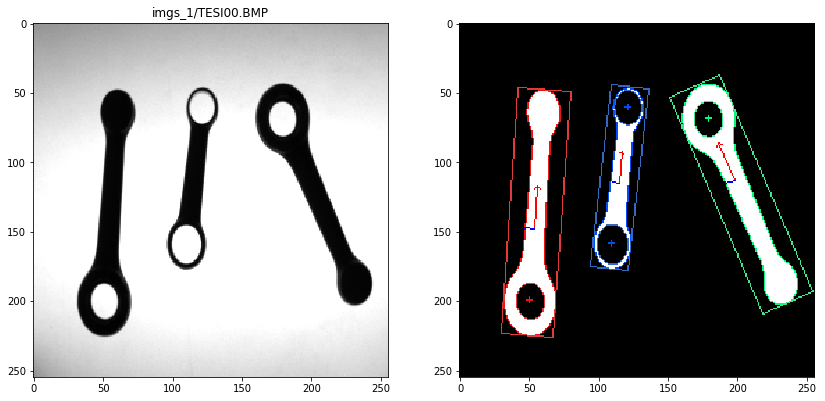

1° rod (Green):
	-Type: A
	-Width: 39.40	Length: 173.81	Bar-Width: 17
	-Holes:
		-1° hole: B=(179.1, 68.8),	d=23.5
2° rod (Blue):
	-Type: B
	-Width: 27.17	Length: 134.54	Bar-Width: 16
	-Holes:
		-1° hole: B=(109.9, 158.9),	d=25.5
		-2° hole: B=(121.1, 60.3),	d=22.0
3° rod (Red):
	-Type: A
	-Width: 37.12	Length: 181.73	Bar-Width: 16
	-Holes:
		-1° hole: B=(51.0, 199.9),	d=23.4
-----------------------------------------------------------------------------------------------------------


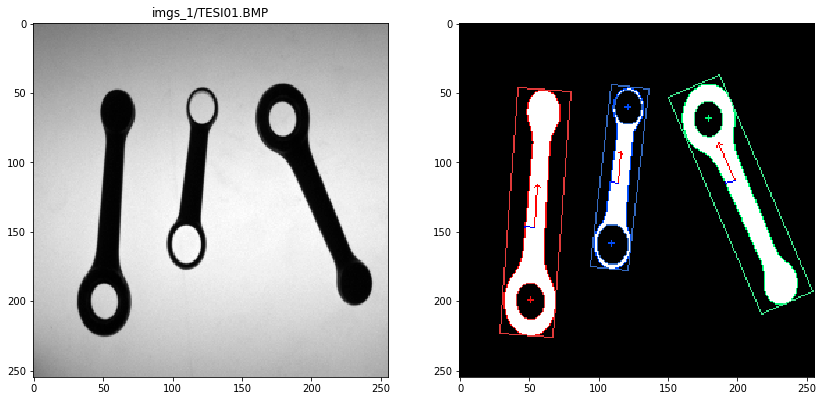

1° rod (Green):
	-Type: A
	-Width: 40.31	Length: 174.40	Bar-Width: 17
	-Holes:
		-1° hole: B=(179.0, 68.7),	d=23.4
2° rod (Blue):
	-Type: B
	-Width: 27.17	Length: 134.54	Bar-Width: 16
	-Holes:
		-1° hole: B=(109.9, 158.9),	d=25.6
		-2° hole: B=(121.1, 60.2),	d=21.9
3° rod (Red):
	-Type: A
	-Width: 38.12	Length: 181.73	Bar-Width: 17
	-Holes:
		-1° hole: B=(51.0, 199.9),	d=23.5
-----------------------------------------------------------------------------------------------------------


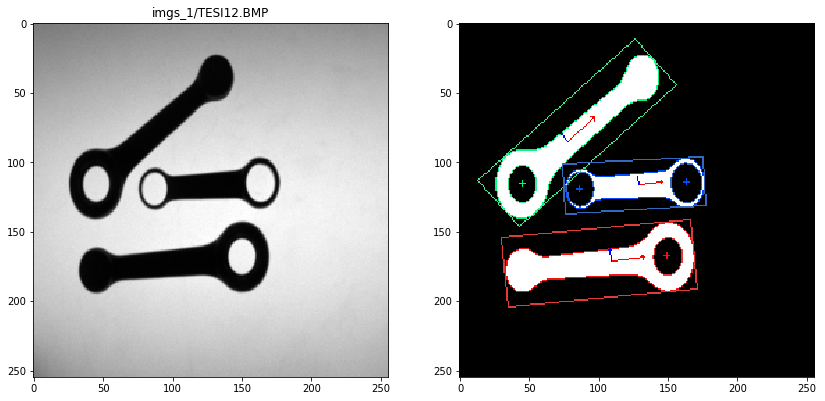

1° rod (Green):
	-Type: A
	-Width: 44.60	Length: 158.47	Bar-Width: 19
	-Holes:
		-1° hole: B=(45.1, 115.5),	d=23.6
2° rod (Blue):
	-Type: B
	-Width: 36.06	Length: 107.15	Bar-Width: 20
	-Holes:
		-1° hole: B=(86.9, 119.1),	d=22.2
		-2° hole: B=(163.1, 114.7),	d=25.5
3° rod (Red):
	-Type: A
	-Width: 50.25	Length: 145.36	Bar-Width: 21
	-Holes:
		-1° hole: B=(149.8, 167.6),	d=24.0
-----------------------------------------------------------------------------------------------------------


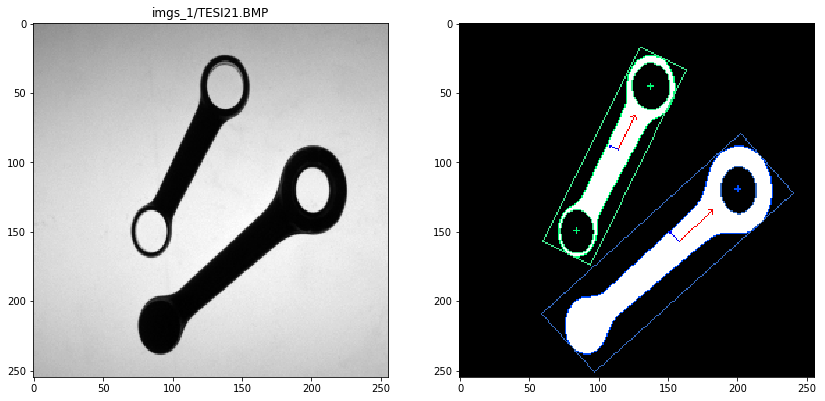

1° rod (Green):
	-Type: B
	-Width: 38.01	Length: 161.07	Bar-Width: 22
	-Holes:
		-1° hole: B=(84.5, 149.7),	d=27.9
		-2° hole: B=(137.7, 45.2),	d=30.6
2° rod (Blue):
	-Type: A
	-Width: 56.64	Length: 201.52	Bar-Width: 24
	-Holes:
		-1° hole: B=(200.6, 119.8),	d=29.5
-----------------------------------------------------------------------------------------------------------


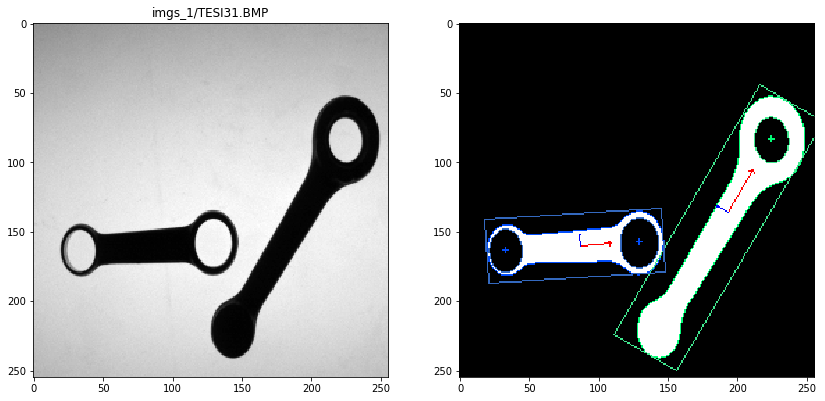

1° rod (Green):
	-Type: A
	-Width: 51.97	Length: 214.56	Bar-Width: 22
	-Holes:
		-1° hole: B=(224.3, 83.9),	d=29.0
2° rod (Blue):
	-Type: B
	-Width: 46.10	Length: 135.25	Bar-Width: 25
	-Holes:
		-1° hole: B=(33.2, 163.7),	d=27.4
		-2° hole: B=(129.3, 157.9),	d=31.9
-----------------------------------------------------------------------------------------------------------


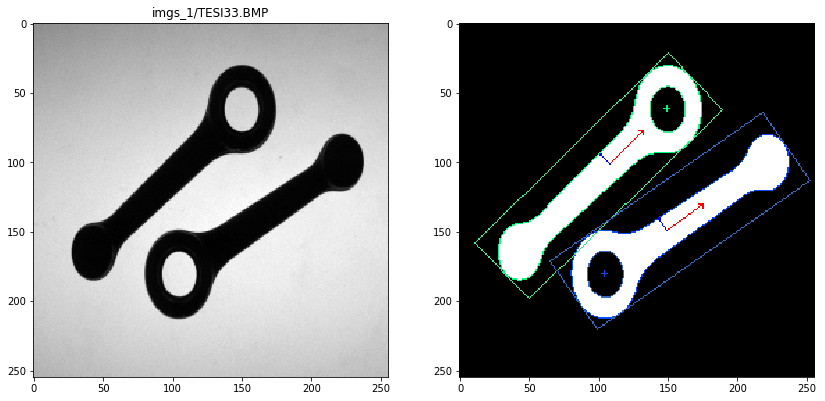

1° rod (Green):
	-Type: A
	-Width: 55.87	Length: 203.30	Bar-Width: 24
	-Holes:
		-1° hole: B=(149.6, 61.7),	d=29.4
2° rod (Blue):
	-Type: A
	-Width: 59.64	Length: 196.21	Bar-Width: 25
	-Holes:
		-1° hole: B=(104.8, 180.4),	d=29.7
-----------------------------------------------------------------------------------------------------------


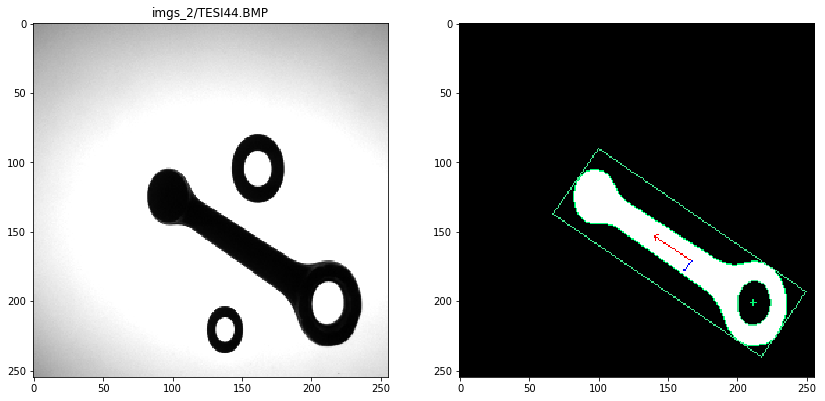

1° rod (Green):
	-Type: A
	-Width: 56.86	Length: 190.42	Bar-Width: 24
	-Holes:
		-1° hole: B=(211.6, 201.2),	d=28.0
-----------------------------------------------------------------------------------------------------------


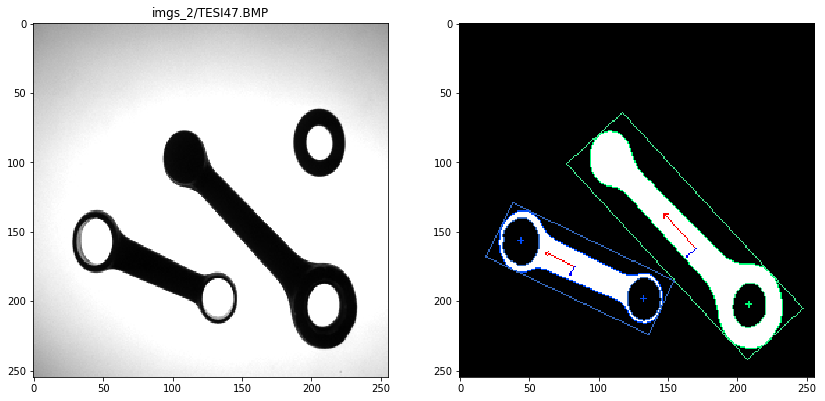

1° rod (Green):
	-Type: A
	-Width: 54.49	Length: 199.29	Bar-Width: 23
	-Holes:
		-1° hole: B=(208.4, 202.9),	d=28.1
2° rod (Blue):
	-Type: B
	-Width: 42.95	Length: 136.07	Bar-Width: 23
	-Holes:
		-1° hole: B=(132.6, 198.2),	d=27.3
		-2° hole: B=(44.2, 156.9),	d=30.1
-----------------------------------------------------------------------------------------------------------


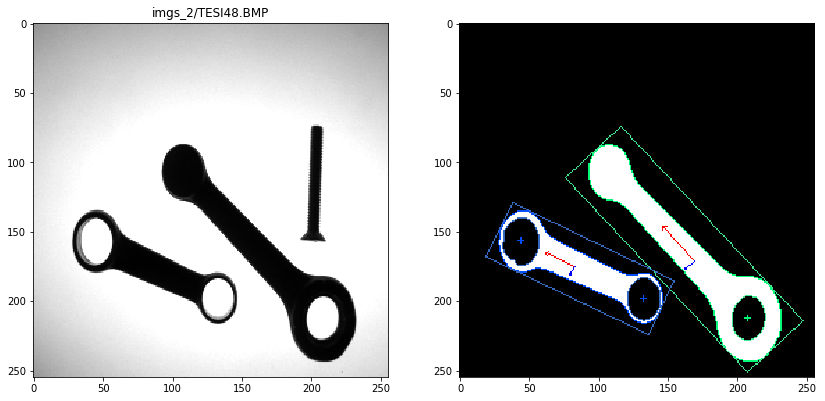

1° rod (Green):
	-Type: A
	-Width: 54.49	Length: 199.62	Bar-Width: 24
	-Holes:
		-1° hole: B=(207.7, 212.0),	d=28.0
2° rod (Blue):
	-Type: B
	-Width: 42.95	Length: 136.07	Bar-Width: 23
	-Holes:
		-1° hole: B=(132.6, 198.2),	d=27.3
		-2° hole: B=(44.3, 156.7),	d=30.0
-----------------------------------------------------------------------------------------------------------


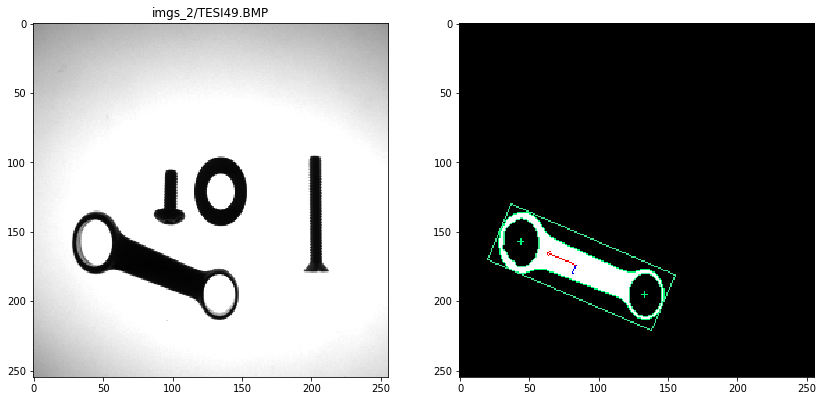

1° rod (Green):
	-Type: B
	-Width: 43.46	Length: 135.45	Bar-Width: 24
	-Holes:
		-1° hole: B=(133.5, 195.4),	d=27.4
		-2° hole: B=(44.4, 157.4),	d=29.8
-----------------------------------------------------------------------------------------------------------


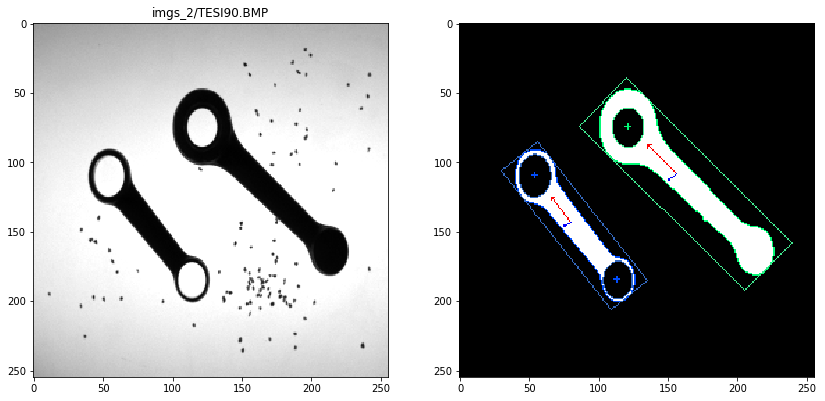

1° rod (Green):
	-Type: A
	-Width: 48.08	Length: 174.54	Bar-Width: 21
	-Holes:
		-1° hole: B=(121.2, 74.7),	d=25.7
2° rod (Blue):
	-Type: B
	-Width: 33.42	Length: 131.40	Bar-Width: 19
	-Holes:
		-1° hole: B=(113.9, 184.8),	d=24.2
		-2° hole: B=(54.1, 109.6),	d=27.1
-----------------------------------------------------------------------------------------------------------


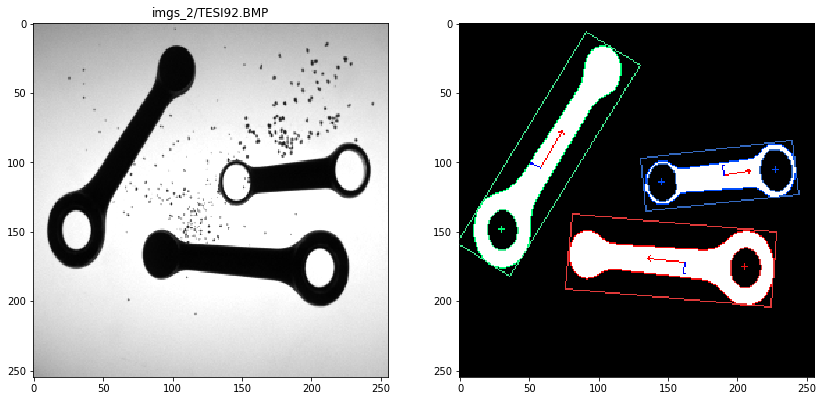

1° rod (Green):
	-Type: A
	-Width: 44.94	Length: 184.39	Bar-Width: 19
	-Holes:
		-1° hole: B=(30.9, 148.7),	d=25.4
2° rod (Blue):
	-Type: B
	-Width: 38.21	Length: 116.73	Bar-Width: 21
	-Holes:
		-1° hole: B=(145.7, 114.4),	d=24.0
		-2° hole: B=(227.6, 105.8),	d=26.6
3° rod (Red):
	-Type: A
	-Width: 54.15	Length: 157.43	Bar-Width: 23
	-Holes:
		-1° hole: B=(205.5, 175.9),	d=25.4
-----------------------------------------------------------------------------------------------------------


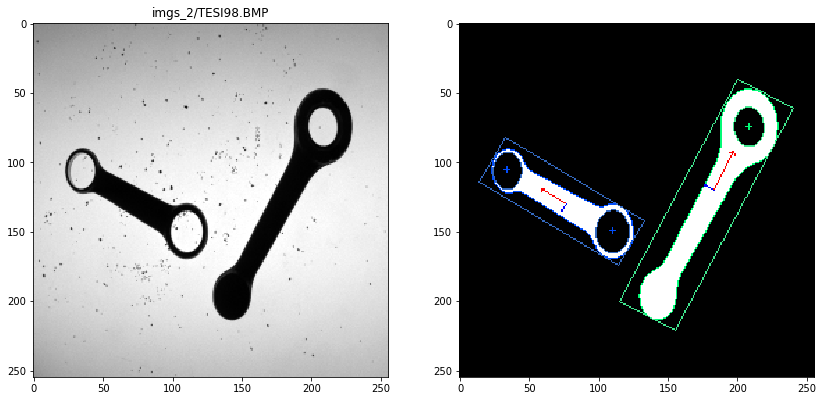

1° rod (Green):
	-Type: A
	-Width: 45.18	Length: 186.51	Bar-Width: 19
	-Holes:
		-1° hole: B=(208.1, 74.3),	d=25.1
2° rod (Blue):
	-Type: B
	-Width: 37.22	Length: 122.25	Bar-Width: 20
	-Holes:
		-1° hole: B=(110.0, 149.8),	d=27.6
		-2° hole: B=(34.4, 106.0),	d=23.8
-----------------------------------------------------------------------------------------------------------


In [21]:
# img_list = [    # All
#     'imgs_1/TESI00.BMP', 'imgs_1/TESI01.BMP', 'imgs_1/TESI12.BMP', 'imgs_1/TESI21.BMP',
#     'imgs_1/TESI31.BMP', 'imgs_1/TESI33.BMP',
#     'imgs_2/TESI44.BMP', 'imgs_2/TESI47.BMP', 'imgs_2/TESI48.BMP', 'imgs_2/TESI49.BMP',
#     'imgs_2/TESI50.BMP', 'imgs_2/TESI51.BMP', 'imgs_2/TESI90.BMP', 'imgs_2/TESI92.BMP',
#     'imgs_2/TESI98.BMP'
# ]

img_list = [    # All minus contact point
    'imgs_1/TESI00.BMP', 'imgs_1/TESI01.BMP', 'imgs_1/TESI12.BMP', 'imgs_1/TESI21.BMP',
    'imgs_1/TESI31.BMP', 'imgs_1/TESI33.BMP',
    'imgs_2/TESI44.BMP', 'imgs_2/TESI47.BMP', 'imgs_2/TESI48.BMP', 'imgs_2/TESI49.BMP',
    'imgs_2/TESI90.BMP', 'imgs_2/TESI92.BMP', 'imgs_2/TESI98.BMP'
]


blob_color = [
    [[2, 250, 118], [65, 232, 143], "Green"],
    [[2, 77, 250], [52, 105, 191], "Blue"],
    [[242, 19, 19], [224, 58, 58], "Red"],
    [[225, 26, 240], [192, 71, 201], "Purple"]
]

for img_name in img_list:
    # Load image
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

    # Binarize and clean the image
    img_bin, th_value = binarizeImage(img)
    #img_bin = removeContactPoints(img_bin)
    img_result, ext_cont, holes_cont, rod_type = findRodContours(img_bin, th_value)

    # Compute Minimum Enclosing Rectangle
    MER_vrtx = []
    barycenters = []
    major_axis = []
    minor_axis = []
    orientation = []

    for c in ext_cont:
        box, B, MA, MI, theta = computeMinimumEnclosingRectangle(c)

        MER_vrtx.append(box)
        barycenters.append(B)
        major_axis.append(MA)
        minor_axis.append(MI)
        orientation.append(theta)

    # Compute Blob Measure
    lengths, widths, b_widths = computeBlobMeasure(img_bin, ext_cont, MER_vrtx, barycenters)
    
    # Draw result
    img_result = drawContour(img_result, ext_cont, holes_cont, blob_color)
    img_result, B_holes, D_holes = drawHoleCenters(img_result, holes_cont, blob_color)
    img_result = drawAxis(img_result, barycenters, orientation, lengths, widths)
    img_result = drawMER(img_result, MER_vrtx, blob_color)

    # Display result
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.title(img_name)
    plt.imshow(img, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(img_result)
    plt.show()

    # Print measure
    for i in range(0, len(rod_type)):
        print("{}° rod ({}):".format(i+1, blob_color[i][2]))
        print("\t-Type: {}".format(rod_type[i]))
        print("\t-Width: {:.2f}\tLength: {:.2f}\tBar-Width: {}".format(widths[i], lengths[i], b_widths[i]))
        print("\t-Holes:")
        for j in range(0, len(B_holes[i])):
            print("\t\t-{}° hole: B=({:.1f}, {:.1f}),\td={:.1f}".format(j+1, B_holes[i][j][0], B_holes[i][j][1], D_holes[i][j]))
    
    print("-----------------------------------------------------------------------------------------------------------")


    
    